# # This file is part of the Python for Data Analysis course.

# 1: • made a bar chart with the number of orders according to the frequency
# 2: • made a bar chart the Altairian Dollars spent on the site by customers


# 1:  X AXIS: FREQUENCY
# #   Y AXIS: CUSTOMERS
# # 
# -- This chart generates a bar chart with frequency of shoppers:
# -- CATEGORIES ARE 0 - 7; 8 - 15; 16 - 23; 24 - 31; 32 - 39
# -- THESE CATEGORIES ARE THE BARS

# 2:  X AXIS: CUSTOMERS
# #   Y AXIS: MONETARY VALUE IN '₳  
# -- This chart generates bars of the lifetime value of customers:
# -- CATEGORIES ARE 0 - 25; 26 - 75; 76 - 125; 126 - 175; 176 - 225
# -- This is the monetary value of the customers in Altairian Dollars (₳)
# -- The Y axis is # amount of customers in the step of 5000 - 0, 5000, 10000, 15000, 20000..                                                                   
                                                            

In [1]:
# run this shit in some terminal
# uv pip install ipykernel
# python -m ipykernel install --user --name=my-uv-env --display-name="Python (uv project)"
# uv pip install psycopg2-binary
# %pip install psycopg2-binary
# %pip install matplotlib
# %pip install pandas
# %pip install seaborn


In [2]:
import sys
import os

# Add the parent directory to sys.path so we can import CONNECT_TO_DB
notebook_dir = os.getcwd()
sys.path.append(os.path.dirname(notebook_dir))

from CONNECT_TO_DB import setup_connection
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

**Structure of the `customers` table:**

| Column Name    | Data Type                                      |
|----------------|------------------------------------------------|
| event_type     | character varying(50)                          |
| product_id     | integer                                        |
| price          | numeric(10,2)                                  |
| user_id        | bigint                                         |
| user_session   | uuid                                           |
| event_time     | timestamp without time zone                    |
| category_id    | bigint                                         |
| category_code  | character varying(255)                         |
| brand          | character varying(255)                         |

QUERY USED IN PRIOR EX.:

```SQL
SELECT 
    user_session, 
    user_id,
    MIN(event_time) AS first_event,
    MAX(event_time) AS last_event,
    COUNT(*) AS event_count,
    SUM(CASE WHEN event_type NOT IN ('view', 'remove_from_cart') THEN price ELSE 0 END) AS price_total,
    SUM(CASE WHEN event_type = 'remove_from_cart' THEN price ELSE 0 END) AS price_subtract,
    SUM(CASE WHEN event_type NOT IN ('view', 'remove_from_cart') THEN price ELSE 0 END) - SUM(CASE WHEN event_type = 'remove_from_cart' THEN price ELSE 0 END) AS basket_session,
    SUM(CASE WHEN event_type = 'purchase' THEN 1 ELSE 0 END) AS purchase_per_session,
    CASE 
        WHEN SUM(CASE WHEN event_type = 'purchase' THEN 1 ELSE 0 END) > 0 THEN TRUE 
        ELSE FALSE 
    END AS has_purchase,
    CASE 
        WHEN SUM(CASE WHEN event_type = 'purchase' THEN 1 ELSE 0 END) = 0 THEN 0
        ELSE 
            (SUM(CASE WHEN event_type != 'view' THEN price ELSE 0 END) - SUM(CASE WHEN event_type = 'remove_from_cart' THEN price ELSE 0 END)) 
            / NULLIF(SUM(CASE WHEN event_type = 'purchase' THEN 1 ELSE 0 END), 0)
    END AS price_per_purchase
FROM public.customers 
WHERE user_session != '00000000-0000-0000-0000-000000000000' 
GROUP BY user_session, user_id
HAVING SUM(CASE WHEN event_type != 'view' THEN price ELSE 0 END) - SUM(CASE WHEN event_type = 'remove_from_cart' THEN price ELSE 0 END) != 0
AND SUM(CASE WHEN event_type = 'purchase' THEN 1 ELSE 0 END) > 0
ORDER BY MIN(event_time);
```

/tmp/ipykernel_1763744/3821516259.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
2025-06-05 21:44:19 [INFO] Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
2025-06-05 21:44:19 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-05 21:44:19 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Customer count per Altairian Dollar bin:
spent_bin
0      1573180
25       44265
75       11176
125       4247
175       2349
225       4126
Name: count, dtype: int64


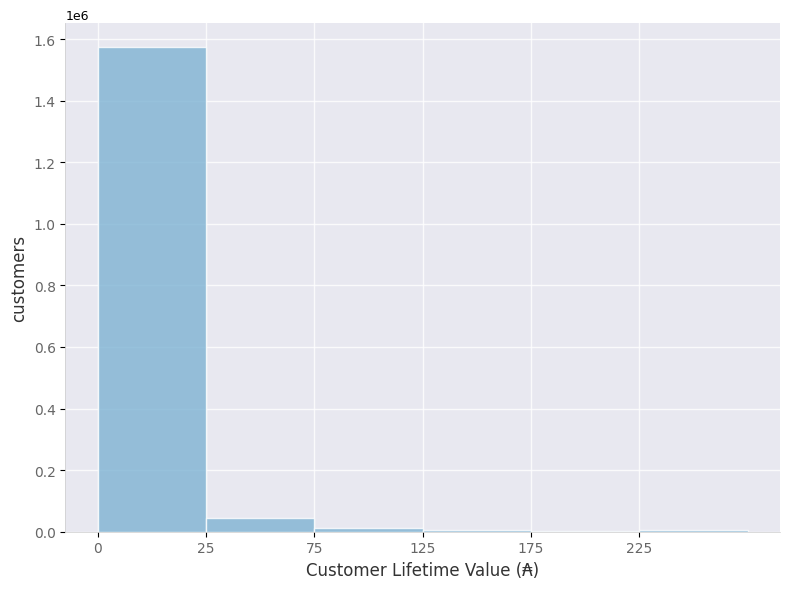

In [22]:
def plot_monetary_bar_exact():
    conn = setup_connection()
    query = """
    SELECT user_id, SUM(CASE WHEN event_type='purchase' THEN price ELSE 0 END) AS total_spent
    FROM customers
    GROUP BY user_id
    """
    df = pd.read_sql(query, conn)
    conn.close()
    
    # Bin monetary values
    bins = [0, 25, 75, 125, 175, 225, float('inf')]
    labels = ['0','25', '75', '125', '175', '225']
    df['spent_bin'] = pd.cut(df['total_spent'], bins=bins, labels=labels, right=True, include_lowest=True)
    spent_counts = df['spent_bin'].value_counts().sort_index()
    
    print("Customer count per Altairian Dollar bin:")
    print(spent_counts)
    
    plt.figure(figsize=(8, 6))
    plt.gca().set_facecolor('#E8E8F0')
    plt.gcf().patch.set_facecolor('white')
    
    # Remove gaps by setting width=1 and aligning bars to edges
    plt.bar(spent_counts.index, spent_counts.values, 
            color='#7FB3D3', alpha=0.8, edgecolor='white', linewidth=1, width=1, align='edge')
    
    plt.xlabel('Customer Lifetime Value (₳)', fontsize=12, color='#333333')
    plt.ylabel('customers', fontsize=12, color='#333333')
    
    plt.xticks(fontsize=10, color='#666666')
    plt.yticks(fontsize=10, color='#666666')
    
    plt.grid(True, color='white', linewidth=1, alpha=0.8)
    plt.gca().set_axisbelow(True)
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_color('#CCCCCC')
    plt.gca().spines['bottom'].set_color('#CCCCCC')
    
    plt.tight_layout()
    plt.show()

plot_monetary_bar_exact()


/tmp/ipykernel_1763744/3342805668.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
2025-06-05 22:02:20 [INFO] Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


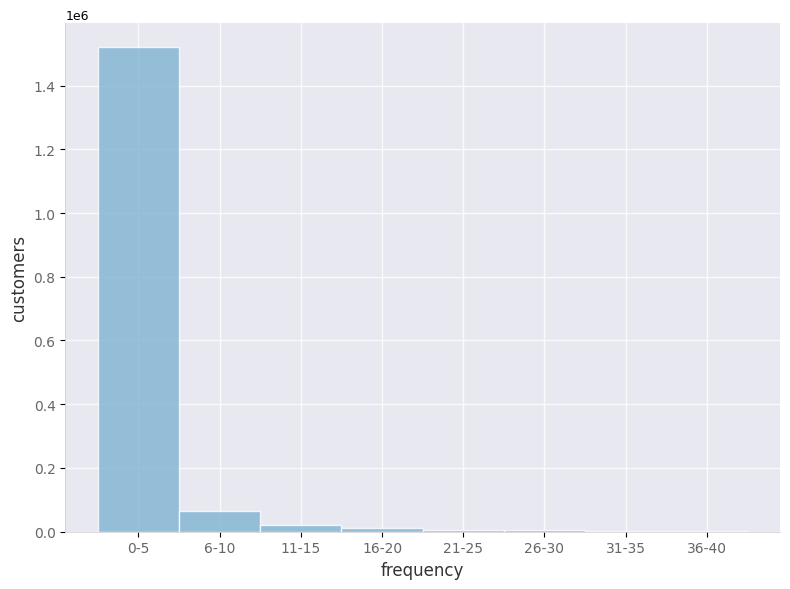

In [30]:
def plot_frequency_histogram_exact():
    conn = setup_connection()
    query = """
    SELECT user_id, COUNT(DISTINCT user_session) AS frequency
    FROM customers
    GROUP BY user_id
    """
    df = pd.read_sql(query, conn)
    conn.close()
    
    # Define bins: 0-5, 6-10, 11-15, 16-20, 21-25, 26-30, 31-35, 36-40
    bins = [0, 6, 11, 16, 21, 26, 31, 36, 41]
    labels = ['0-5', '6-10', '11-15', '16-20', '21-25', '26-30', '31-35', '36-40']
    df['freq_bin'] = pd.cut(df['frequency'], bins=bins, labels=labels, right=False, include_lowest=True)
    freq_counts = df['freq_bin'].value_counts().sort_index()

    plt.figure(figsize=(8, 6))
    plt.gca().set_facecolor('#E8E8F0')
    plt.gcf().patch.set_facecolor('white')
    
    plt.bar(labels, freq_counts.values, 
            color='#7FB3D3', alpha=0.8, edgecolor='white', linewidth=1, width=1, align='center')
    
    plt.xlabel('frequency', fontsize=12, color='#333333')
    plt.ylabel('customers', fontsize=12, color='#333333')
    plt.xticks(fontsize=10, color='#666666')
    plt.yticks(fontsize=10, color='#666666')
    plt.grid(True, color='white', linewidth=1, alpha=0.8)
    plt.gca().set_axisbelow(True)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_color('#CCCCCC')
    plt.gca().spines['bottom'].set_color('#CCCCCC')
    plt.tight_layout()
    plt.show()

plot_frequency_histogram_exact()


In [14]:
import sys
import os
import logging
from datetime import datetime
from collections import defaultdict
import matplotlib.pyplot as plt

# Set global matplotlib style to match target aesthetic
plt.rcParams.update({
    'font.size': 10,
    'axes.labelsize': 10,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'axes.titlesize': 0,
    'figure.figsize': (8, 5),
    'axes.grid': True,
    'axes.facecolor': '#f5f5f8',
    'figure.facecolor': 'white',
    'axes.edgecolor': '#e0e0e0',
    'axes.linewidth': 0.5,
    'font.family': 'sans-serif',
    'grid.color': '#ffffff',
    'grid.linewidth': 1,
    'grid.alpha': 0.8
})

def ensure_output_dir():
    output_dir = os.path.join(os.path.dirname(os.path.abspath("")), '../generated')
    os.makedirs(output_dir, exist_ok=True)
    return output_dir

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s [%(levelname)s] %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

def log_and_run(func, description):
    logging.info(f"Started generating {description}...")
    start_time = datetime.now()
    func()
    end_time = datetime.now()
    logging.info(f"Finished generating {description} in {(end_time - start_time).total_seconds():.2f} seconds.")